## Using Linear Regession for Market Movement Prediction

In [23]:
import os
import random
import numpy as np
import pandas as pd
from pylab import mpl, plt
import pandas_datareader.data as web
plt.style.use('seaborn')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['PYTHONHASSEED'] = '0'

In [6]:
x = np.linspace(0,10)

def set_seed(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
set_seed()

In [7]:
y = x + np.random.standard_normal(len(x))

In [10]:
reg = np.polyfit(x,y,deg=1)
reg

array([0.94612934, 0.22855261])

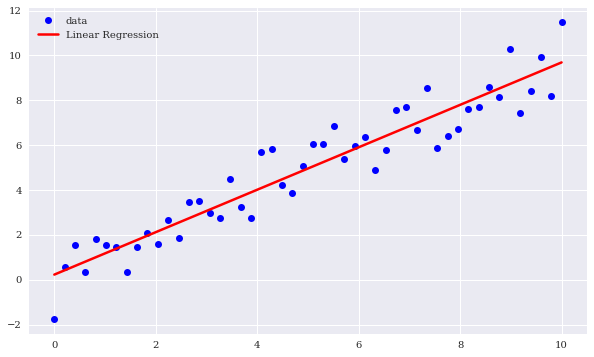

In [13]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'bo',label = 'data')

plt.plot(x,np.polyval(reg,x),'r',lw=2.5, label='Linear Regression')
plt.legend(loc=0)

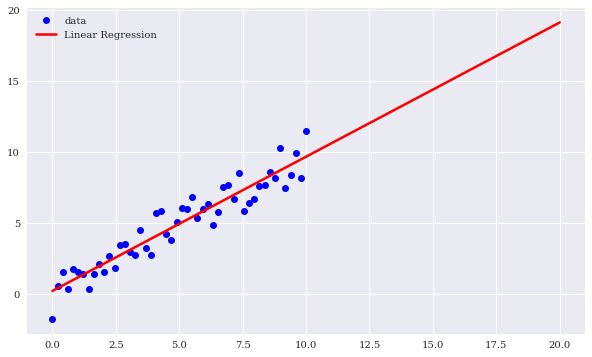

In [14]:
plt.figure(figsize=(10,6))
plt.plot(x,y,'bo',label = 'data')
xn = np.linspace(0,20)
plt.plot(xn,np.polyval(reg,xn),'r',lw=2.5, label='Linear Regression')
plt.legend(loc=0)

## The Basic Idea for price Predictions

In [16]:
x = np.arange(12)
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [18]:
lags = 3
m = np.zeros((lags+1, len(x)-lags))

m[lags] = x[lags:]
for i in range(lags):
    m[i] = x[i:i - lags]
m.T

array([[ 0.,  1.,  2.,  3.],
       [ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.],
       [ 3.,  4.,  5.,  6.],
       [ 4.,  5.,  6.,  7.],
       [ 5.,  6.,  7.,  8.],
       [ 6.,  7.,  8.,  9.],
       [ 7.,  8.,  9., 10.],
       [ 8.,  9., 10., 11.]])

In [19]:
m

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
       [ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]])

In [20]:
reg = np.linalg.lstsq(m[:lags].T, m[lags], rcond = None)[0]

In [21]:
reg

array([-0.66666667,  0.33333333,  1.33333333])

In [22]:
np.dot(m[:lags].T,reg)

array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

In [24]:
data = web.DataReader('WIPRO.NS', 'yahoo', '2016-01-01','2022-09-30')

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1652 entries, 2016-01-01 to 2022-09-08
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       1652 non-null   float64
 1   Low        1652 non-null   float64
 2   Open       1652 non-null   float64
 3   Close      1652 non-null   float64
 4   Volume     1652 non-null   float64
 5   Adj Close  1652 non-null   float64
dtypes: float64(6)
memory usage: 90.3 KB


In [27]:
lags = 5
cols = []

for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = data['Close'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols],data['Close'], rcond=None)[0]

In [28]:
reg

array([ 1.05134657, -0.08001791,  0.07659505, -0.02070602, -0.02707637])

<AxesSubplot:xlabel='Date'>

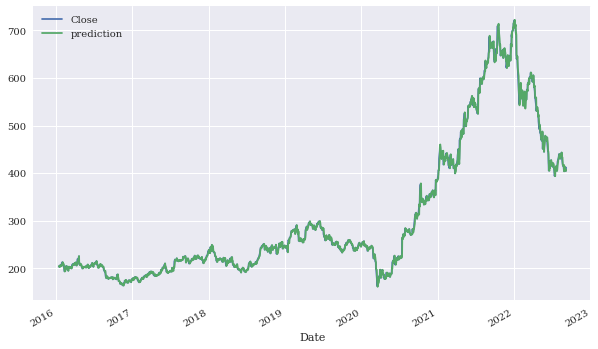

In [30]:
data['prediction'] = np.dot(data[cols],reg)
data[['Close','prediction']].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

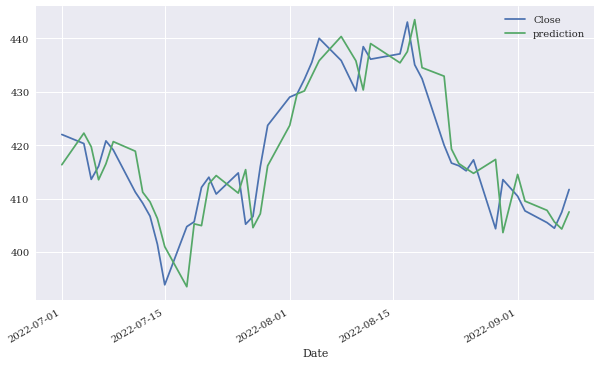

In [34]:
data[['Close','prediction']].loc['2022-07-01':].plot(figsize=(10,6))

In [35]:
data['return'] = np.log(data['Close']/data['Close'].shift(1))
data.dropna(inplace=True)

cols = []
for lag in range(1, lags+1):
    col = f'lag_{lag}'
    data[col] = data['return'].shift(lag)
    cols.append(col)
data.dropna(inplace=True)

In [36]:
reg = np.linalg.lstsq(data[cols], data['return'],rcond=None)[0]

In [37]:
reg

array([-0.00465249,  0.01704574,  0.03880469, -0.00164023,  0.03492817])

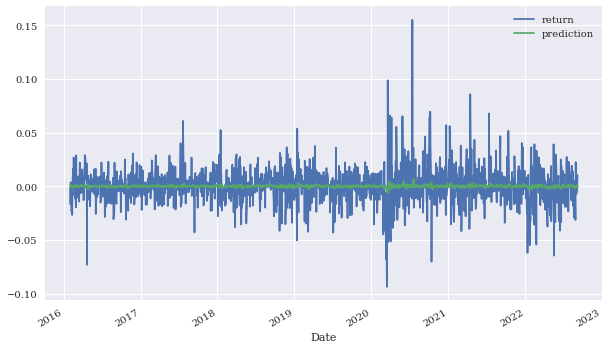

In [38]:
data['prediction'] = np.dot(data[cols],reg)
data[['return','prediction']].iloc[lags:].plot(figsize=(10,6));

In [39]:
hits = np.sign(data['return']*data['prediction']).value_counts()
hits

 1.0    857
-1.0    772
 0.0      7
dtype: int64

In [40]:
hits.values[0]/sum(hits)

0.523838630806846

## predicting Future Market Direction

In [41]:
reg = np.linalg.lstsq(data[cols], np.sign(data['return']), rcond = None)[0]
reg

array([ 0.63691184,  0.52523504,  2.80610983, -0.49395254,  1.40825379])

In [43]:
data['prediction'] = np.sign(np.dot(data[cols], reg))
data['prediction'].value_counts()

 1.0    843
-1.0    793
Name: prediction, dtype: int64

In [44]:
hits = np.sign(data['return']*data['prediction']).value_counts()
hits

 1.0    847
-1.0    782
 0.0      7
dtype: int64

In [45]:
hits.values[0]/sum(hits)

0.5177261613691931

## Vecortized Backtesting of Regression - Based Strategy

In [46]:
data.head()

,High,Low,Open,Close,Volume,Adj Close,lag_1,lag_2,lag_3,lag_4,lag_5,predction,prediction,return
Date,,,,,,,,,,,,,,
2016-01-25,206.175049,203.925049,205.462555,205.143799,2121412.0,199.389954,-0.001272,0.015092,0.001014,-0.009457,0.007430,206.171690,1.0,-0.005560
2016-01-27,208.106308,203.831299,206.250046,207.206299,5580259.0,201.394592,-0.005560,-0.001272,0.015092,0.001014,-0.009457,205.275200,1.0,0.010004
2016-01-28,207.637558,204.150055,207.450058,205.218796,3229764.0,199.462814,0.010004,-0.005560,-0.001272,0.015092,0.001014,207.445374,-1.0,-0.009638
2016-01-29,212.137558,205.725052,205.725052,211.050049,3867287.0,205.130508,-0.009638,0.010004,-0.005560,-0.001272,0.015092,205.024844,1.0,0.028019
2016-02-01,215.212555,208.987549,212.100052,213.056305,4018593.0,207.080490,0.028019,-0.009638,0.010004,-0.005560,-0.001272,211.503315,1.0,0.009461


In [47]:
data['strategy'] = data['prediction']*data['return']

In [48]:
data[['return', 'strategy']].sum().apply(np.exp)

return      1.995758
strategy    1.663979
dtype: float64

<AxesSubplot:xlabel='Date'>

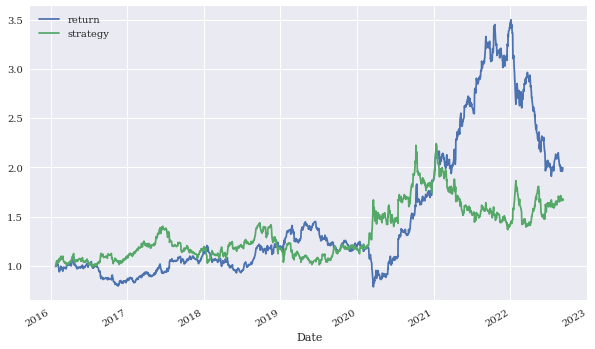

In [49]:
data[['return', 'strategy']].dropna().cumsum().apply(np.exp).plot(figsize=(10,6))

# Using Machine Learning for Market Movement Prediction

In [ ]:
                                                                                                                                                                ```````````````````````````````````n